In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Logistic regression

Text(0, 0.5, 'logistic(z)')

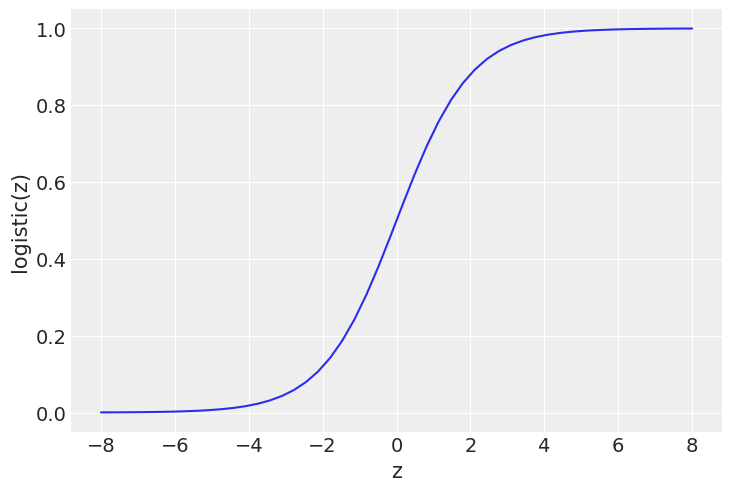

In [5]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')
# plt.savefig('B11197_04_01.png', dpi=300);

## The iris dataset

In [6]:
iris = pd.read_csv('../data/iris.csv')
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='species', ylabel='sepal_length'>

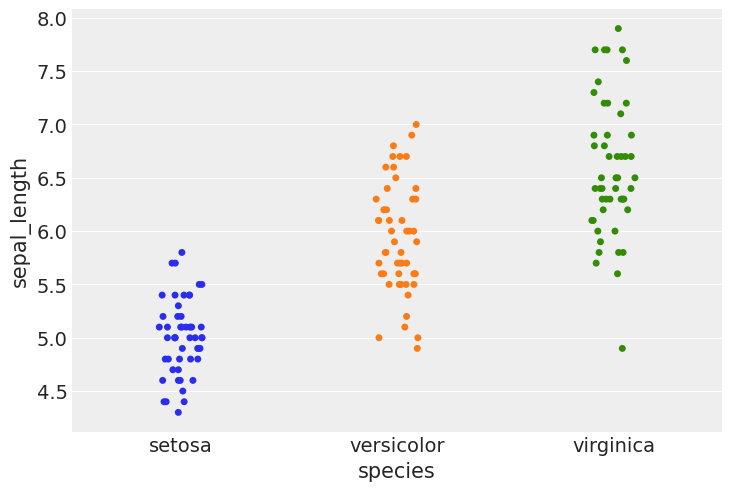

In [7]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
# plt.savefig('B11197_04_02.png', dpi=300);

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.tight_layout(*args, **kwargs)


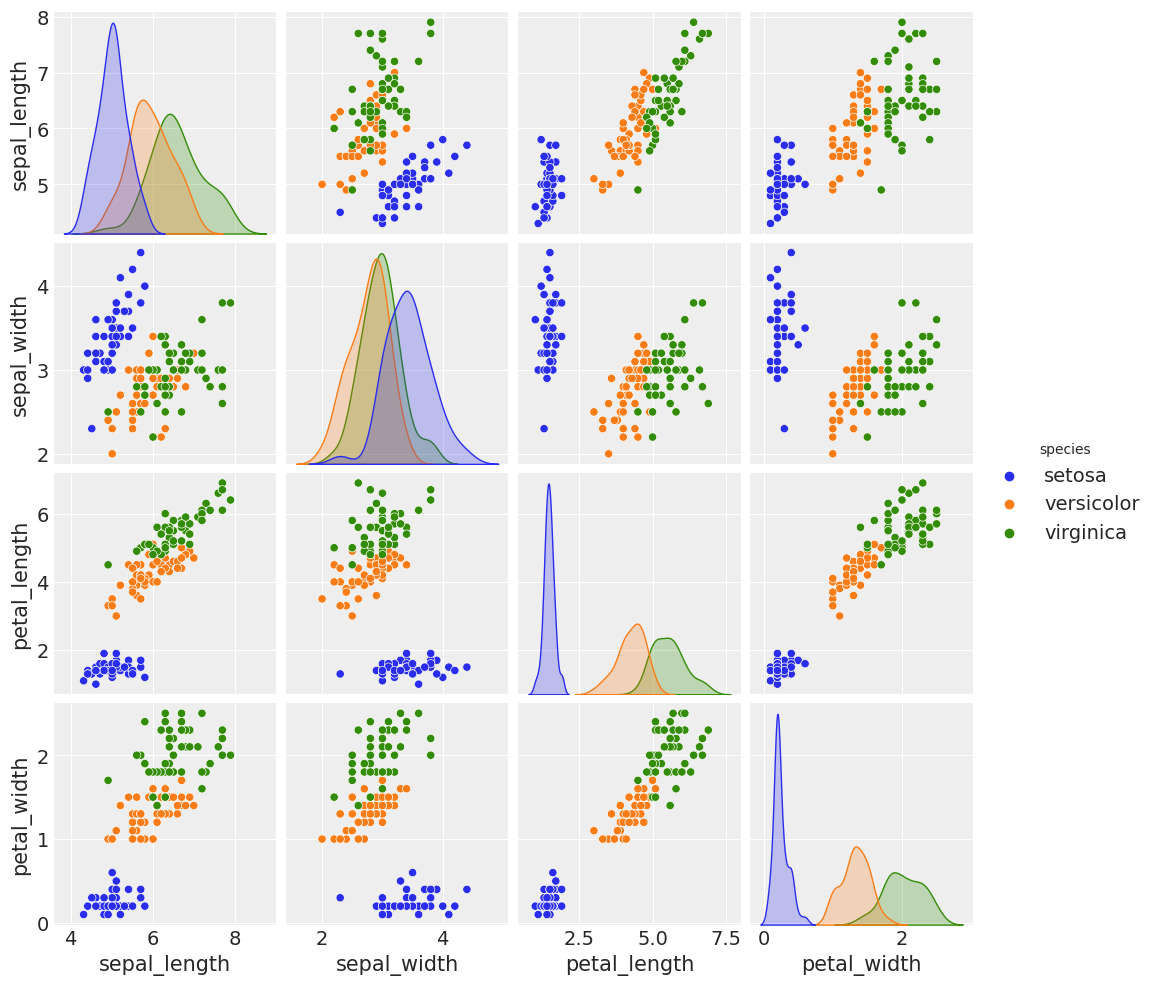

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde')
# plt.savefig('B11197_04_03.png', dpi=300, bbox_inches='tight');

### The logistic model applied to the iris dataset

In [15]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [12]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=8)
    β = pm.Normal('β', mu=0, sd=6)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    trace_0 = pm.sample(1000, cores=2)

/tmp/ipykernel_42009/3060786707.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_0 = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
/tmp/ipykernel_42009/801328045.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_0 = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8898550704972839, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
varnames = ['α', 'β', 'bd']
az.summary(trace_0, varnames)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.310,0.343,-0.284,0.970,0.009,0.007,1520.0,1117.0,1.0
β,5.278,0.996,3.388,7.048,0.026,0.019,1533.0,1196.0,1.0
bd,-0.058,0.065,-0.171,0.066,0.002,0.001,1596.0,1341.0,1.0


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


([<matplotlib.axis.XTick at 0x7fbfec69e460>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

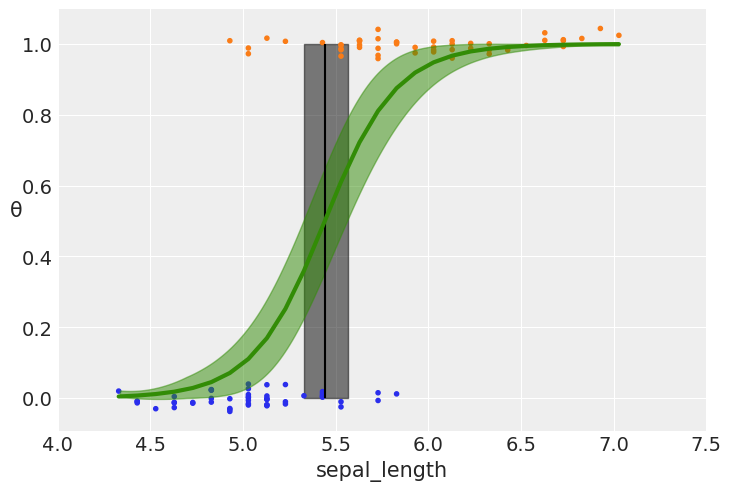

In [19]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, trace_0['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
# plt.savefig('B11197_04_04.png', dpi=300)

# Multiple logistic regression

In [10]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [11]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=7)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000, cores=2)

/tmp/ipykernel_8600/4198394929.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8814279264009411, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


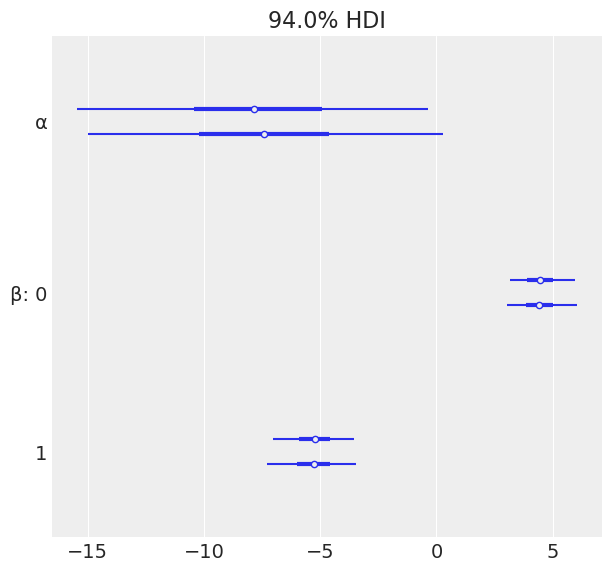

In [12]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'e')

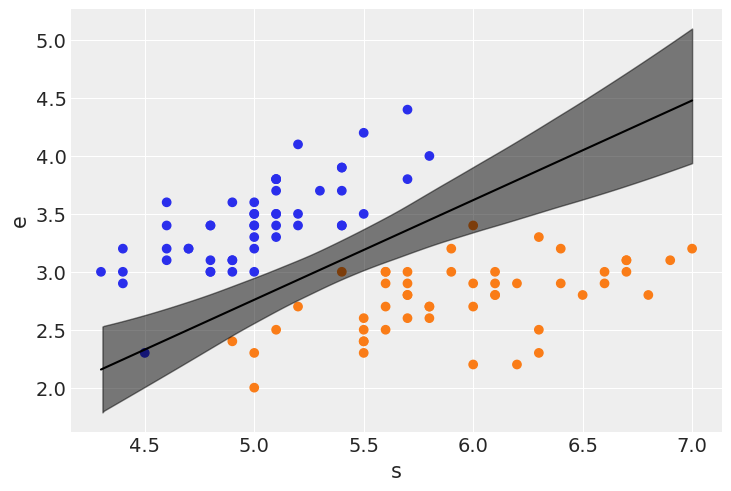

In [16]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hdi(x_1[:,0], trace_1['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
# plt.savefig('B11197_04_05.png', dpi=300);

## Interpreting the coefficients of a logistic regression

/tmp/ipykernel_8600/3905748988.py:2: RuntimeWarning: divide by zero encountered in true_divide
  odds = probability / (1 - probability)


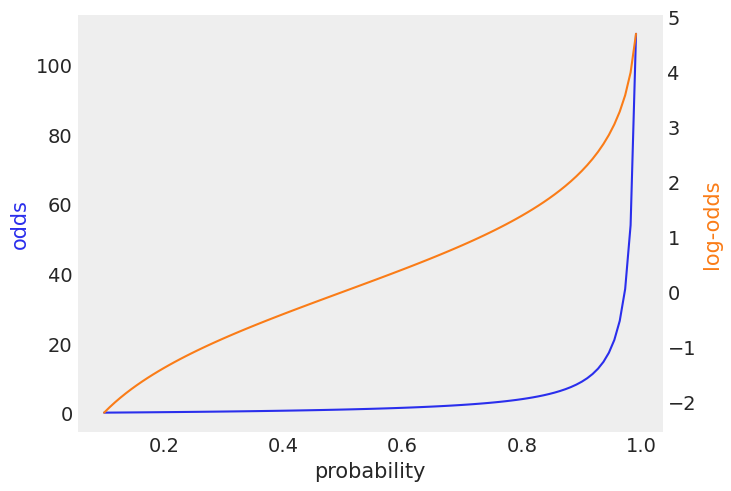

In [17]:
probability = np.linspace(0.1, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
# plt.savefig('B11197_04_06.png', dpi=300);

In [18]:
df = az.summary(trace_1, var_names=varnames)
df

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-7.626,4.080,-15.096,0.198,0.110,0.078,1380.0,1397.0,1.0
β[0],4.461,0.791,3.079,6.010,0.024,0.017,1031.0,973.0,1.0
β[1],-5.307,0.996,-7.256,-3.568,0.030,0.021,1112.0,1022.0,1.0


In [19]:
x_1 = 4.45  # sepal_length
x_2 = 2.995   # sepal_width

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)

log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.4609999999999985, 0.6633899713203537)

## Dealing with correlated variables

<AxesSubplot:>

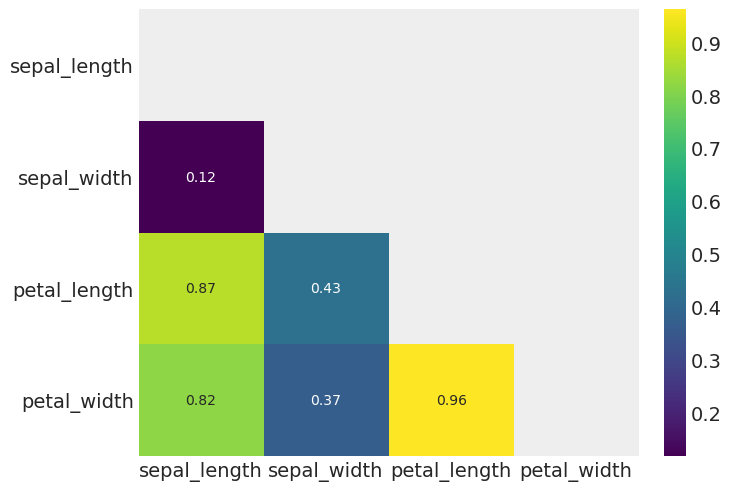

In [29]:
cor0 = iris.corr()
mask = np.tri(*cor0.shape).T
sns.heatmap(cor0.abs(), mask=mask, annot=True, cmap='viridis')

<AxesSubplot:>

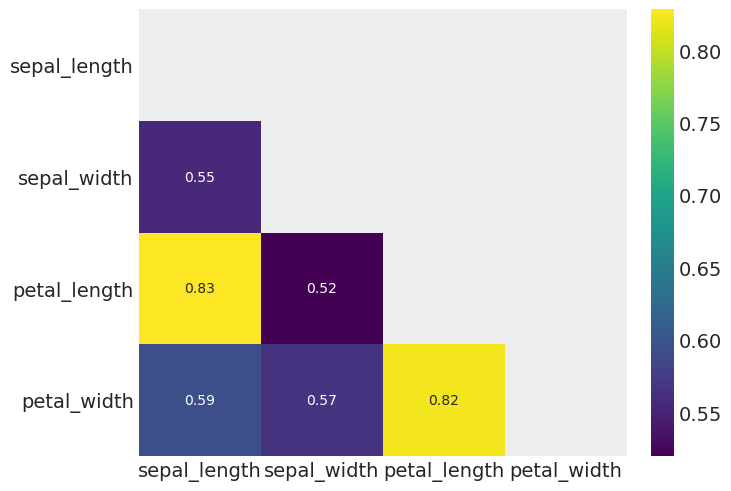

In [22]:
corr = iris[iris['species'] != 'setosa'].corr()
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
# plt.savefig('B11197_04_07.png', dpi=300, bbox_inches='tight');

## Dealing with unbalanced classes

In [30]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [31]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
    trace_3 = pm.sample(1000, cores=2)

/tmp/ipykernel_8600/1470959769.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
#az.plot_trace(trace_3, varnames);

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'sepal_width')

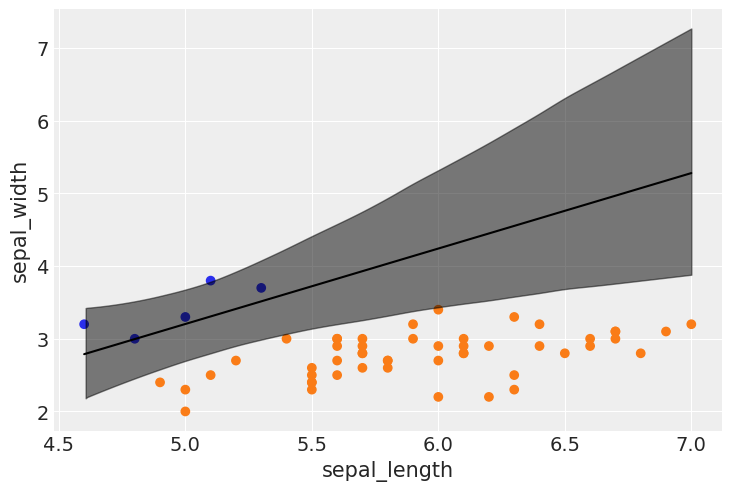

In [33]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
# plt.savefig('B11197_04_08.png', dpi=300);

## Softmax regression

In [35]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [36]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=4.5, shape=3)
    β = pm.Normal('β', mu=0, sd=4.5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000,cores=2)

/tmp/ipykernel_8600/3354330260.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_s = pm.sample(2000,cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.


In [25]:
#az.plot_forest(trace_s, var_names=['α', 'β']);

In [39]:
data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [41]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0.5, sd=3, shape=2)
    β = pm.Normal('β', mu=0, sd=4.5, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000,cores=2)

/tmp/ipykernel_8600/4099158542.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_sf = pm.sample(1000,cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [56]:
az.summary(trace_sf)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],4.531,1.597,1.909,7.664,0.057,0.041,798.0,795.0,1.0
α[1],-3.500,1.973,-7.185,0.012,0.073,0.051,743.0,710.0,1.0
"β[0,0]",3.345,2.473,-0.972,8.243,0.104,0.073,568.0,808.0,1.0
"β[0,1]",2.289,2.509,-2.121,7.043,0.104,0.073,585.0,837.0,1.0
"β[1,0]",-2.781,1.372,-5.409,-0.285,0.067,0.047,428.0,832.0,1.0
"β[1,1]",-3.762,1.527,-6.478,-0.757,0.072,0.051,444.0,821.0,1.0
"β[2,0]",2.638,2.644,-2.039,7.881,0.097,0.071,736.0,838.0,1.0
"β[2,1]",9.468,2.909,4.002,14.763,0.105,0.074,763.0,1025.0,1.0
"β[3,0]",2.618,2.642,-2.284,7.317,0.102,0.072,660.0,941.0,1.0
"β[3,1]",8.876,2.889,3.852,14.292,0.106,0.075,731.0,739.0,1.0


## Discriminative and generative models

In [55]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sd=7, shape=2)
    σ = pm.HalfNormal('σ', 5)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,  observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000,cores=2)

/tmp/ipykernel_8600/3748082212.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_lda = pm.sample(1000,cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


Text(0.5, 0, 'sepal_length')

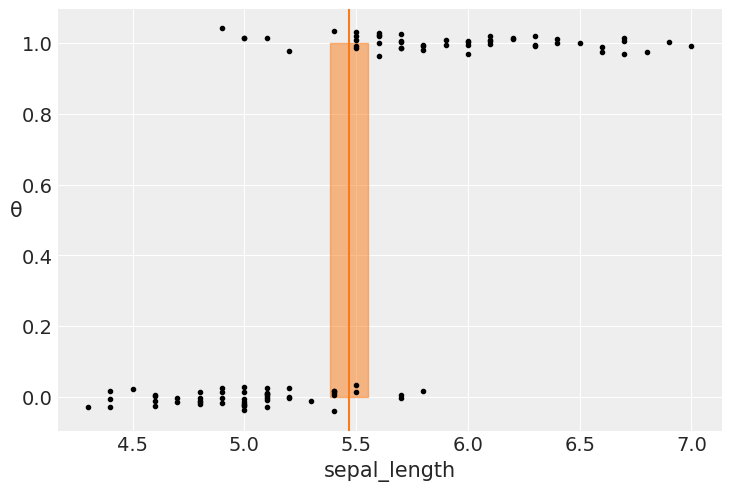

In [58]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
# plt.savefig('B11197_04_09.png', dpi=300)

In [59]:
az.summary(trace_lda)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.003,0.064,4.884,5.123,0.001,0.001,2462.0,1446.0,1.0
μ[1],5.936,0.063,5.820,6.056,0.001,0.001,2730.0,1433.0,1.0
σ,0.449,0.033,0.393,0.514,0.001,0.000,2375.0,1378.0,1.0
bd,5.469,0.045,5.381,5.552,0.001,0.001,2546.0,1362.0,1.0


### The Poisson distribution

Text(0, 0.5, 'f(x)')

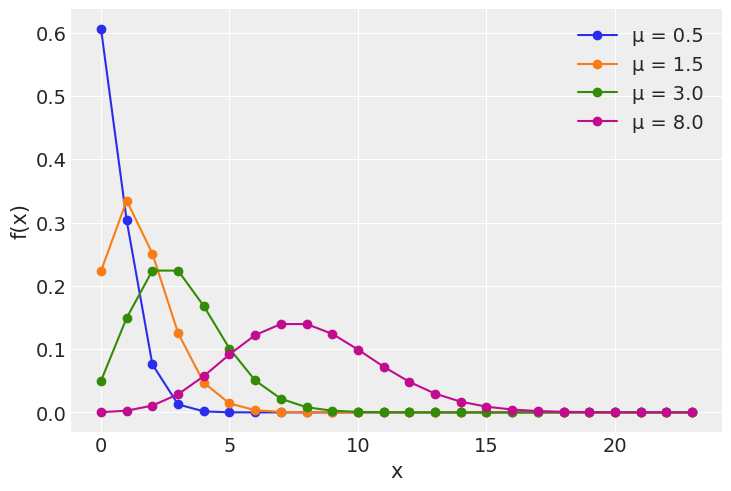

In [3]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
# plt.savefig('B11197_04_10.png', dpi=300);

## The Zero-Inflated Poisson model

In [4]:
n = 100
θ_real = 2.5
ψ = 0.1
# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * np.random.poisson(θ_real) for i in range(n)])

In [5]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ, observed=counts)
    trace = pm.sample(1000, cores=2)

/tmp/ipykernel_5534/3013683072.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'ψ'}>,
        <AxesSubplot:title={'center':'ψ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

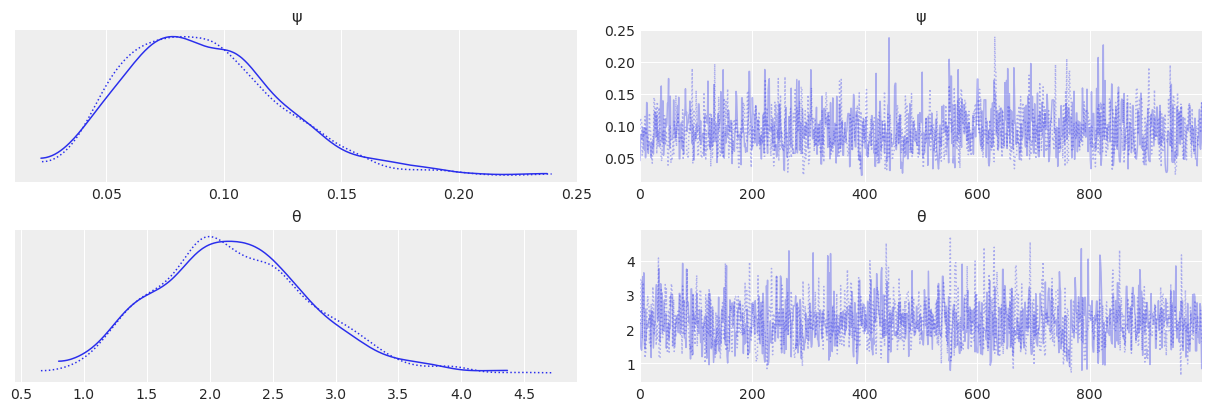

In [7]:
az.plot_trace(trace)
# plt.savefig('B11197_04_11.png', dpi=300);

In [35]:
#az.summary(trace)

## Poisson regression and ZIP regression

In [8]:
fish_data = pd.read_csv('../data/fish.csv')

/tmp/ipykernel_5534/1466556121.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ZIP_reg = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


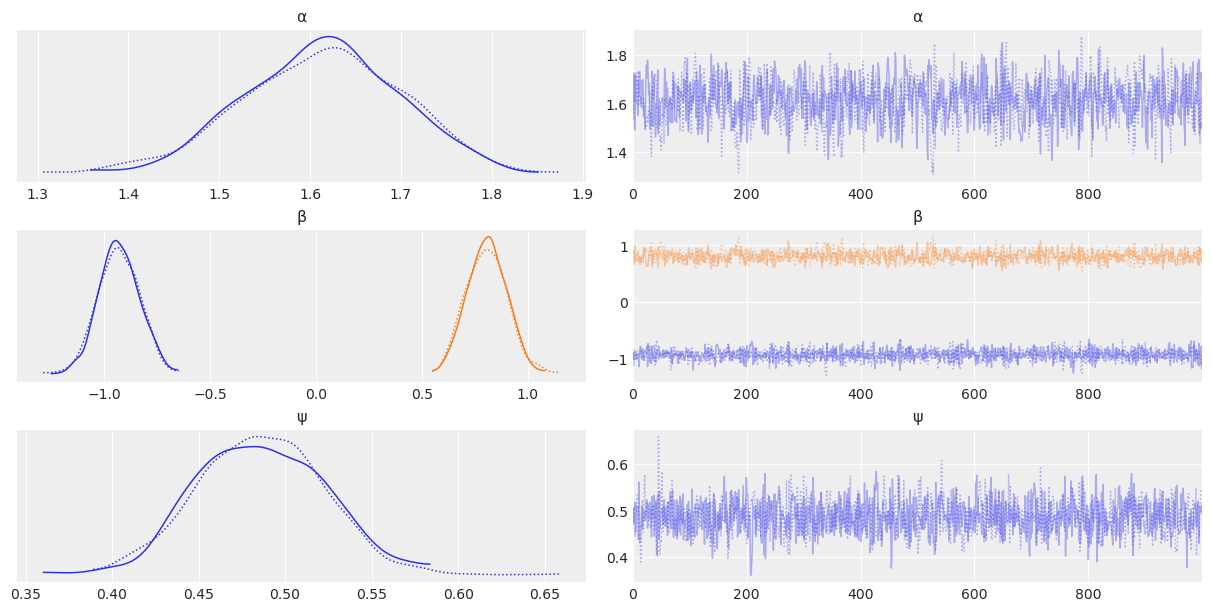

In [15]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 9)
    β = pm.Normal('β', 0, 7, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000, cores=2)
az.plot_trace(trace_ZIP_reg);

In [21]:
az.summary(trace_ZIP_reg)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.613,0.088,1.465,1.792,0.003,0.002,1017.0,905.0,1.0
β[0],-0.932,0.098,-1.104,-0.741,0.002,0.002,1896.0,1188.0,1.0
β[1],0.808,0.096,0.625,0.976,0.003,0.002,988.0,1021.0,1.0
ψ,0.486,0.037,0.419,0.553,0.001,0.001,1566.0,1122.0,1.0


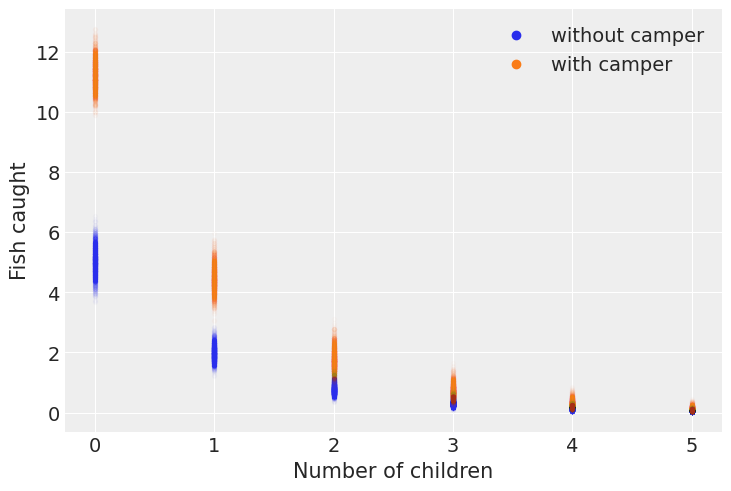

In [17]:
children = [0, 1, 2, 3, 4, 5]
fish_count_pred_0 = []
fish_count_pred_1 = []

for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
# plt.savefig('B11197_04_12.png', dpi=300);

## Robust logistic regression

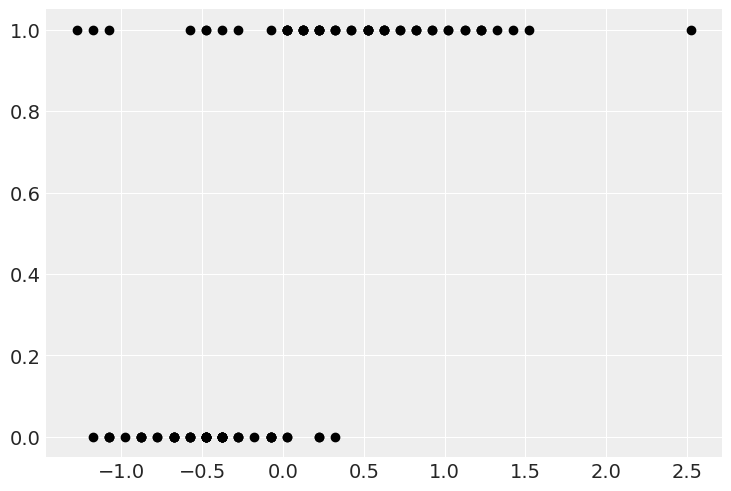

In [31]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.3, 4.2, 4.4, 6.0, 6.5, 8.0]))
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [32]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + x_c *  β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    trace_rlg = pm.sample(1000, cores=2)

/tmp/ipykernel_5534/3047615284.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_rlg = pm.sample(1000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


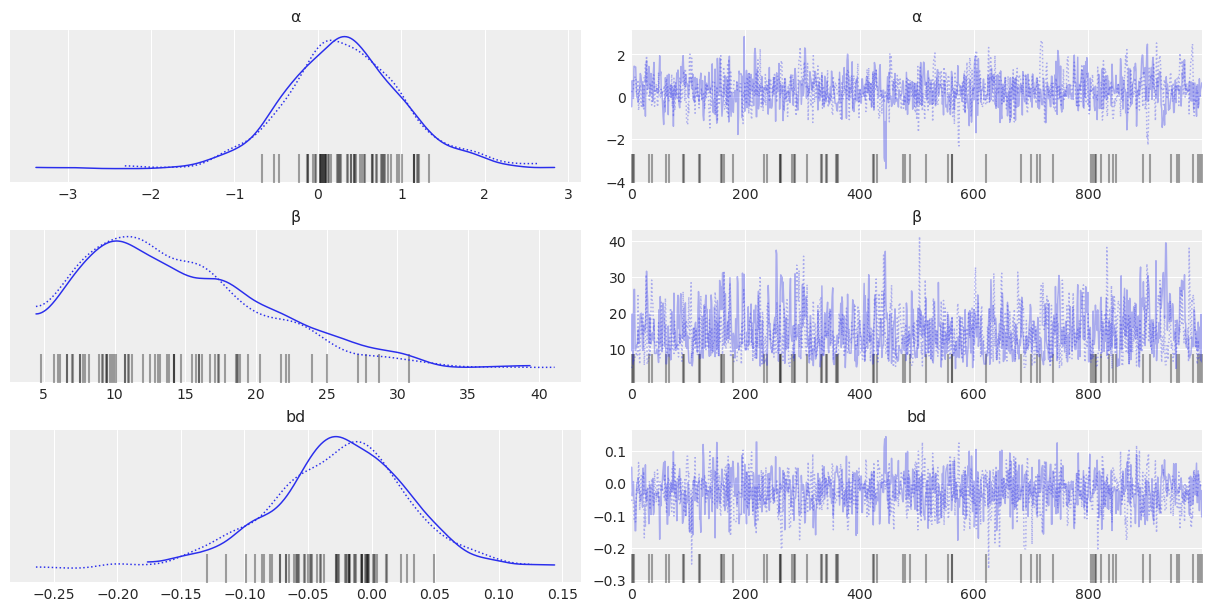

In [34]:
az.plot_trace(trace_rlg, varnames);

In [35]:
varnames = ['α', 'β', 'bd']
az.summary(trace_rlg, varnames)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.326,0.719,-1.086,1.703,0.023,0.018,1015.0,950.0,1.0
β,14.546,6.340,4.772,25.838,0.256,0.183,627.0,812.0,1.0
bd,-0.026,0.055,-0.128,0.082,0.002,0.001,1134.0,1311.0,1.0


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


([<matplotlib.axis.XTick at 0x7feb9069e760>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5'),
  Text(2.5, 0, '8.0'),
  Text(3.0, 0, '8.5')])

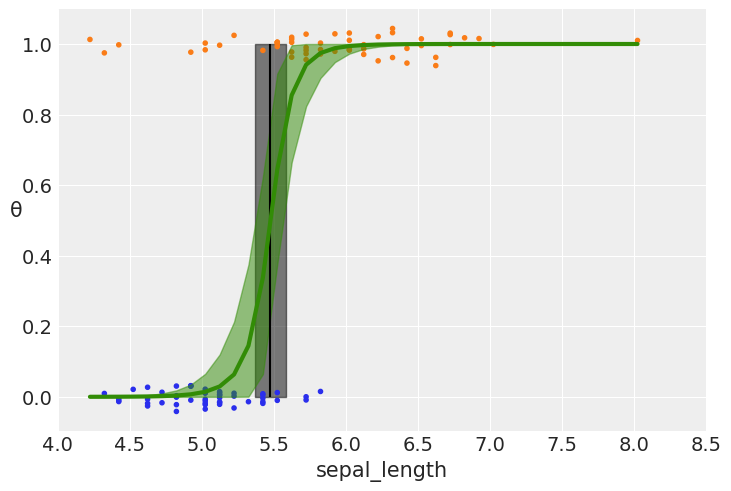

In [36]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(trace_rlg['bd'])

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hdi(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
# plt.savefig('B11197_04_13.png', dpi=300);